# 10.1 GroupBy机制

Hadley Wickham（许多热门R语言包的作者）创造了一个用于表示分组运算的术语"split-apply-combine"（拆分－应用－合并）。第一个阶段，pandas对象（无论是Series、DataFrame还是其他的）中的数据会根据你所提供的一个或多个键被拆分（split）为多组。拆分操作是在对象的特定轴上执行的。例如，DataFrame可以在其行（axis=0）或列（axis=1）上进行分组。然后，将一个函数应用（apply）到各个分组并产生一个新值。最后，所有这些函数的执行结果会被合并（combine）到最终的结果对象中。结果对象的形式一般取决于数据上所执行的操作。图10-1大致说明了一个简单的分组聚合过程。
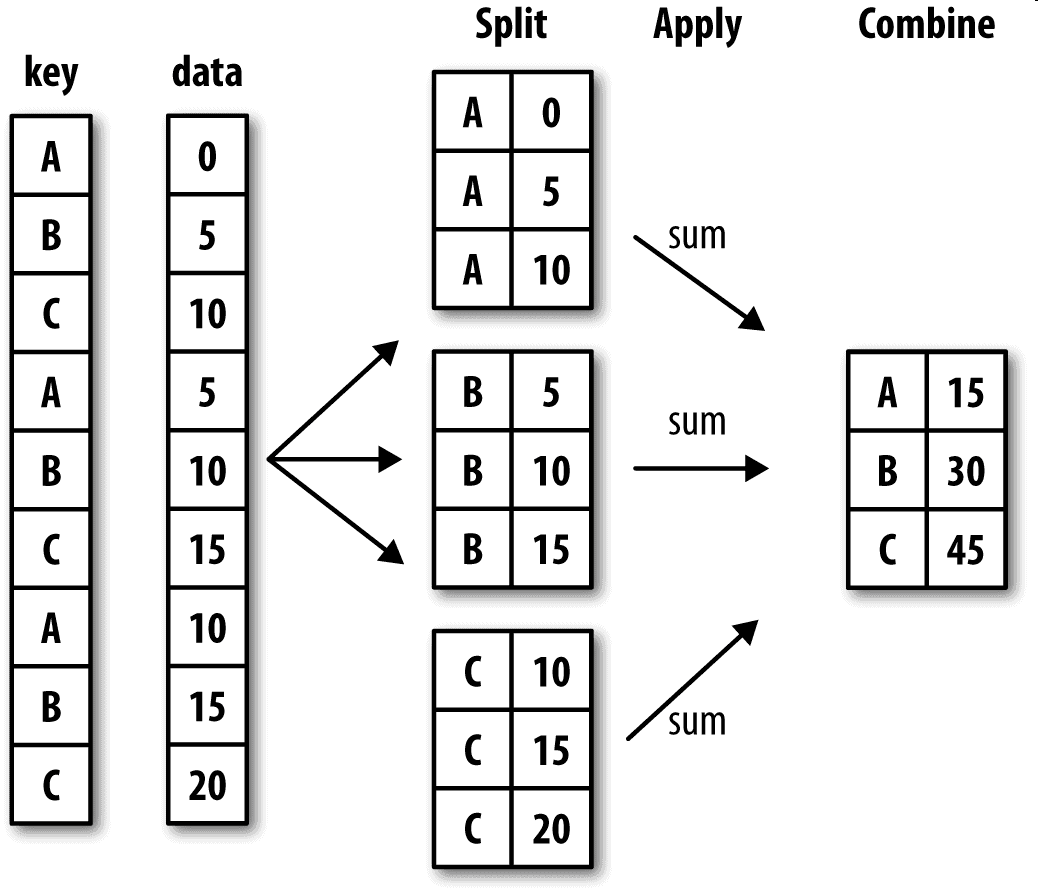

In [2]:
import pandas as pd
import numpy as np
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5), 'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.531133,-1.213723
1,a,two,0.128986,-0.143254
2,b,one,-0.462311,0.185491
3,b,two,1.067639,-0.446146
4,a,one,-0.576907,0.516573


In [9]:
#访问data1，并根据key1调用groupby：按key1进行分组，并计算data1列的平均值
grouped = df['data1'].groupby(df['key1'])
grouped.mean()

key1
a   -0.326351
b    0.302664
Name: data1, dtype: float64

In [4]:
#如果我们一次传入多个数组的列表，
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one    -0.554020
      two     0.128986
b     one    -0.462311
      two     1.067639
Name: data1, dtype: float64

In [5]:
means.unstack()

key2,one,two
key1,,
a,-0.554020,0.128986
b,-0.462311,1.067639


In [6]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005    0.128986
            2006   -0.462311
Ohio        2005    0.268253
            2006   -0.576907
Name: data1, dtype: float64

In [10]:
#分组信息就位于相同的要处理DataFrame中。这里，你还可以将列名（可以是字符串、数字或其他Python对象）用作分组键：
df.groupby('key1').mean()

,data1,data2
key1,,
a,-0.326351,-0.280135
b,0.302664,-0.130328


In [11]:
df.groupby(['key1','key2']).mean()

data1     data2
key1 key2                    
a    one  -0.554020 -0.348575
     two   0.128986 -0.143254
b    one  -0.462311  0.185491
     two   1.067639 -0.446146

In [12]:
#无论你准备拿groupby做什么，都有可能会用到GroupBy的size方法，它可以返回一个含有分组大小的Series：
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

## 对分组进行迭代

In [13]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2     data1     data2
0    a  one -0.531133 -1.213723
1    a  two  0.128986 -0.143254
4    a  one -0.576907  0.516573
b
  key1 key2     data1     data2
2    b  one -0.462311  0.185491
3    b  two  1.067639 -0.446146


In [14]:
#对于多重键的情况，元组的第一个元素将会是由键值组成的元组：
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one -0.531133 -1.213723
4    a  one -0.576907  0.516573
('a', 'two')
  key1 key2     data1     data2
1    a  two  0.128986 -0.143254
('b', 'one')
  key1 key2     data1     data2
2    b  one -0.462311  0.185491
('b', 'two')
  key1 key2     data1     data2
3    b  two  1.067639 -0.446146


In [15]:
#将这些数据片段做成一个字典：
pieces = dict(list(df.groupby('key1')))
pieces['b']

,key1,key2,data1,data2
2,b,one,-0.462311,0.185491
3,b,two,1.067639,-0.446146


## 选取一列或列的子集

In [16]:
df.groupby('key1')['data1'] #df['data1'].groupby(df['key1'])
df.groupby('key1')[['data2']] #df[['data2']].groupby(df['key1'])

#这种索引操作所返回的对象是一个已分组的DataFrame（如果传入的是列表或数组）或已分组的Series（如果传入的是标量形式的单个列名）：
df.groupby(['key1', 'key2'])[['data2']].mean()  #dataFrame

data2
key1 key2          
a    one  -0.348575
     two  -0.143254
b    one   0.185491
     two  -0.446146

In [17]:
df.groupby(['key1', 'key2'])['data2'].mean() #Series

key1  key2
a     one    -0.348575
      two    -0.143254
b     one     0.185491
      two    -0.446146
Name: data2, dtype: float64

## 通过字典或Series进行分组

In [18]:
#除数组以外，分组信息还可以其他形式存在。来看另一个示例DataFrame：
people = pd.DataFrame(np.random.randn(5, 5),columns=['a', 'b', 'c', 'd', 'e'],index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values
people

,a,b,c,d,e
Joe,-0.586031,-1.086833,-0.542471,-0.081868,0.410371
Steve,-0.533217,-1.785327,-0.422651,-0.692828,0.749628
Wes,-1.954825,NaN,NaN,-0.525011,1.317162
Jim,0.453112,-0.270518,-0.693928,-0.906381,-2.349423
Travis,1.695848,0.941015,-1.078737,-0.847397,-0.982774


In [19]:
#当然我们可以直接根据列名分组，但根据字典分组可以说是再深入一层（隐藏了dict的value层），从而根据value分组
#我们可以直接传递字典（我包含了键“f”来强调，存在未使用的分组键是可以的）：
mapping = {'a': 'red', 'b': 'red', 'c': 'blue','d': 'blue', 'e': 'red', 'f' : 'orange'}
by_column = people.groupby(mapping, axis=1) #注意这里axis=1因为是根据列来分组
by_column.sum()

,blue,red
Joe,-0.624339,-1.262493
Steve,-1.115479,-1.568917
Wes,-0.525011,-0.637663
Jim,-1.600309,-2.166829
Travis,-1.926135,1.654089


In [20]:
#Series也有同样的功能，它可以被看做一个固定大小的映射：
map_series = pd.Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [21]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


## 通过函数进行分组

比起使用字典或Series，使用Python函数是一种更原生的方法定义分组映射。

In [24]:
#根据人名的长度来分组
people.groupby(len).sum()

,a,b,c,d,e
3,-2.087745,-1.357351,-1.236399,-1.513260,-0.621889
5,-0.533217,-1.785327,-0.422651,-0.692828,0.749628
6,1.695848,0.941015,-1.078737,-0.847397,-0.982774


In [25]:
#将函数跟数组、列表、字典、Series混合使用也不是问题，因为任何东西在内部都会被转换为数组：
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len,key_list]).min()

a         b         c         d         e
3 one -1.954825 -1.086833 -0.542471 -0.525011  0.410371
  two  0.453112 -0.270518 -0.693928 -0.906381 -2.349423
5 one -0.533217 -1.785327 -0.422651 -0.692828  0.749628
6 two  1.695848  0.941015 -1.078737 -0.847397 -0.982774

## 根据索引级别分组

层次化索引数据集最方便的地方就在于它能够根据轴索引的一个级别进行聚合：

In [26]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'], [1, 3, 5, 1, 3]], names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.791869 -0.822961 -1.066139 -0.656414  0.028918
1      0.193139 -0.011887  0.319690  0.948128  0.207420
2     -0.330569 -0.130219 -0.372549  2.408027  1.366391
3     -0.756603  1.039018  0.225976 -0.393159 -0.554041

In [27]:
#要根据级别分组，使用level关键字传递级别序号或名字：
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


# 10.2 数据聚合

聚合指的是任何能够从数组产生标量值的数据转换过程。之前的例子已经用过一些，比如mean、count、min以及sum等。你可能想知道在GroupBy对象上调用mean()时究竟发生了什么。许多常见的聚合运算（如表10-1所示）都有进行优化。
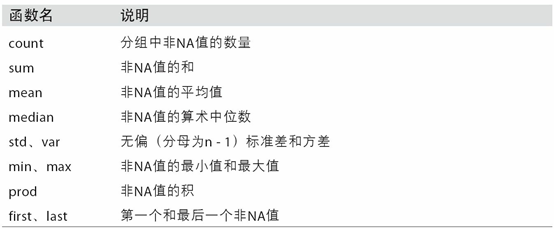

In [30]:
df = pd.DataFrame({'data1':np.random.randn(5),'data2':np.random.randn(5),'key1':['a','a','b','b','a'],'key2':['one','two','one','two','one']})
df

,data1,data2,key1,key2
0,-0.236772,-1.378300,a,one
1,1.805133,0.146511,a,two
2,1.254669,0.665887,b,one
3,1.106053,0.556329,b,two
4,0.594205,-0.188012,a,one


In [31]:
grouped = df.groupby('key1')
grouped['data1'].mean()

key1
a    0.720855
b    1.180361
Name: data1, dtype: float64

In [32]:
#如果要使用你自己的聚合函数，只需将其传入aggregate或agg方法即可：
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.041905,1.524811
b,0.148616,0.109558


In [33]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.720855  1.026827 -0.236772  0.178717  0.594205  1.199669   
b      2.0  1.180361  0.105088  1.106053  1.143207  1.180361  1.217515   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     1.805133   3.0 -0.473267  0.801430 -1.378300 -0.783156 -0.188012   
b     1.254669   2.0  0.611108  0.077469  0.556329  0.583718  0.611108   

                          
           75%       max  
key1                      
a    -0.020750  0.146511  
b     0.638497  0.665887

## 面向列的多函数应用

## 以“没有行索引”的形式返回聚合数据

到目前为止，所有示例中的聚合数据都有由唯一的分组键组成的索引（可能还是层次化的）。由于并不总是需要如此，所以你可以向groupby传入as_index=False以禁用该功能：
tips.groupby(['day', 'smoker'], as_index=False).mean()

# 10.3 apply：一般性的“拆分－应用－合并”

In [39]:
data = pd.DataFrame({'a':np.random.randint(2,size=5),'b':np.random.randn(5)})
data

,a,b
0,0,0.358904
1,0,-0.984473
2,1,0.119459
3,0,1.239193
4,0,1.609398


In [41]:
def top(df,n=3,column='b'):
    return df.sort_values(by=column)[-n:]
data.groupby('a').apply(top)

a         b
a               
0 0  0  0.358904
  3  0  1.239193
  4  0  1.609398
1 2  1  0.119459

这里发生了什么？top函数在DataFrame的各个片段上调用，然后结果由pandas.concat组装到一起，并以分组名称进行了标记。于是，最终结果就有了一个层次化索引，其内层索引值来自原DataFrame。

In [43]:
#如果传给apply的函数能够接受其他参数或关键字，则可以将这些内容放在函数名后面一并传入：
data.groupby(['a']).apply(top, n=1)

,,a,b
a,,,
0,4,0,1.609398
1,2,1,0.119459


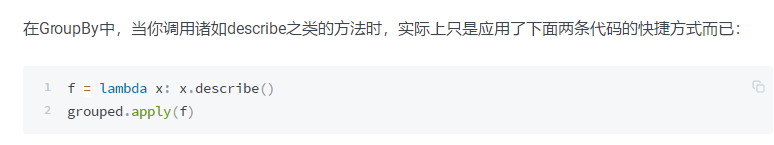

## 禁止分组键

In [44]:
#从上面的例子中可以看出，分组键会跟原始对象的索引共同构成结果对象中的层次化索引。将group_keys=False传入groupby即可禁止该效果：
data.groupby('a',group_keys=False).apply(top)

,a,b
0,0,0.358904
3,0,1.239193
4,0,1.609398
2,1,0.119459


## 分位数和桶分析

In [45]:
frame = pd.DataFrame({'data1': np.random.randn(1000),'data2': np.random.randn(1000)})
quartiles = pd.cut(frame.data1, 4)
quartiles[:10]

0      (0.309, 1.821]
1      (0.309, 1.821]
2     (-1.204, 0.309]
3    (-2.723, -1.204]
4     (-1.204, 0.309]
5      (0.309, 1.821]
6     (-1.204, 0.309]
7      (0.309, 1.821]
8    (-2.723, -1.204]
9      (0.309, 1.821]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-2.723, -1.204] < (-1.204, 0.309] < (0.309, 1.821] < (1.821, 3.334]]

In [48]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),'count': group.count(), 'mean': group.mean()}
grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-2.723, -1.204]",118.0,2.875488,0.053277,-2.763986
"(-1.204, 0.309]",503.0,3.257555,0.087739,-2.908771
"(0.309, 1.821]",354.0,3.512043,0.000282,-2.152909
"(1.821, 3.334]",25.0,1.404838,-0.048486,-1.212747


In [49]:
#这些都是长度相等的桶。要根据样本分位数得到大小相等的桶，使用qcut即可。传入labels=False即可只获取分位数的编号：
grouping = pd.qcut(frame.data1, 10, labels=False)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.875488,0.017512,-2.763986
1,100.0,3.257555,0.240148,-2.908771
2,100.0,2.108812,0.059045,-2.643097
3,100.0,2.698912,0.020725,-2.685447
4,100.0,2.184477,0.021234,-2.201764
5,100.0,2.434725,0.184853,-1.764884
6,100.0,3.512043,-0.153348,-2.701795
7,100.0,2.890774,0.095134,-1.718015
8,100.0,2.017167,-0.039413,-2.111412


## 示例：用特定于分组的值填充缺失值

In [50]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1   -0.536426
2         NaN
3   -1.300581
4         NaN
5   -1.188565
dtype: float64

In [51]:
s.fillna(s.mean())

0   -1.008524
1   -0.536426
2   -1.008524
3   -1.300581
4   -1.008524
5   -1.188565
dtype: float64

假设你需要对不同的分组填充不同的值。一种方法是将数据分组，并使用apply和一个能够对各数据块调用fillna的函数即可。下面是一些有关美国几个州的示例数据，这些州又被分为东部和西部：

In [52]:
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = pd.Series(np.random.randn(8), index=states)
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio         -1.034108
New York     -0.565557
Vermont            NaN
Florida      -0.892208
Oregon        0.157467
Nevada             NaN
California    0.072887
Idaho              NaN
dtype: float64

In [53]:
data.groupby(group_key).mean()

East   -0.830624
West    0.115177
dtype: float64

In [54]:
fill_mean = lambda g:g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio         -1.034108
New York     -0.565557
Vermont      -0.830624
Florida      -0.892208
Oregon        0.157467
Nevada        0.115177
California    0.072887
Idaho         0.115177
dtype: float64

In [55]:
#另外，也可以在代码中预定义各组的填充值。由于分组具有一个name属性，所以我们可以拿来用一下：
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

Ohio         -1.034108
New York     -0.565557
Vermont       0.500000
Florida      -0.892208
Oregon        0.157467
Nevada       -1.000000
California    0.072887
Idaho        -1.000000
dtype: float64

## 示例：随机采样和排列

In [56]:
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)

deck = pd.Series(card_val, index=cards)
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [57]:
def draw(deck, n=5):
     return deck.sample(n)
    
#假设你想要从每种花色中随机抽取两张牌。由于花色是牌名的最后一个字符，所以我们可以据此进行分组，并使用apply：
get_suit = lambda card: card[-1] # last letter is suit
deck.groupby(get_suit).apply(draw, n=2)

C  JC    10
   4C     4
D  JD    10
   3D     3
H  QH    10
   6H     6
S  QS    10
   7S     7
dtype: int64

In [58]:
#或者，也可以这样写：
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

5C     5
QC    10
9D     9
AD     1
7H     7
9H     9
4S     4
5S     5
dtype: int64

## 示例：分组加权平均数和相关系数

In [59]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a','b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),'weights': np.random.rand(8)})
df

,category,data,weights
0,a,-0.516674,0.952895
1,a,-0.401689,0.429964
2,a,1.397387,0.795713
3,a,1.344039,0.324430
4,b,-1.042309,0.322534
5,b,-0.410496,0.165431
6,b,-0.158322,0.185031
7,b,-1.884499,0.710809


In [60]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

category
a    0.352743
b   -1.281179
dtype: float64

# 10.4 透视表和交叉表

透视表（pivot table）是各种电子表格程序和其他数据分析软件中一种常见的数据汇总工具。它根据一个或多个键对数据进行聚合，并根据行和列上的分组键将数据分配到各个矩形区域中。在Python和pandas中，可以通过本章所介绍的groupby功能以及（能够利用层次化索引的）重塑运算制作透视表。DataFrame有一个pivot_table方法，此外还有一个顶级的pandas.pivot_table函数。除能为groupby提供便利之外，pivot_table还可以添加分项小计，也叫做margins。
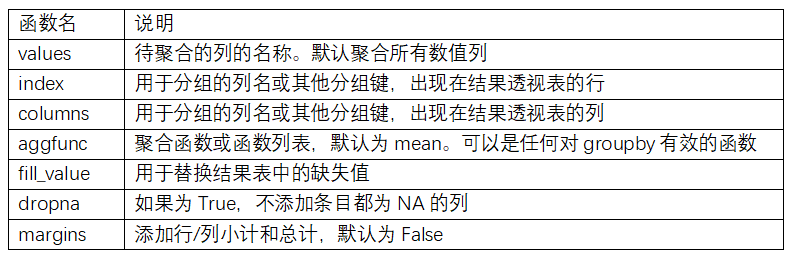

## 交叉表